In [1]:
import typing
from scipy.sparse import spmatrix, csr_matrix
import torch
import torchvision
from scipy.spatial.distance import squareform
import scipy
from numba import jit
import numpy as np
from matplotlib import pyplot as plt
import functools

import paradime as prdm

In [2]:
%load_ext memory_profiler

In [10]:
foo = prdm.relations.DifferentiablePDist().compute_relations(
    torch.rand((100,100))
)
choice = np.random.choice(np.arange(100), 20, replace=False)

d:\Dokumente\Dissertation\Code\Python\paradime\paradime\relations.py:337: UserWarning: Differentiable pdist operating on tensor for which no gradients are computed.
  warnings.warn(


In [11]:
foo

In [3]:
%timeit foo.to_square_array().sub(choice)

83.3 µs ± 2.92 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%timeit squareform(foo.data.numpy())

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [12]:
import itertools

In [16]:
len(list(itertools.combinations(choice, 2)))

190

In [26]:
%timeit new_sub(foo.data, choice)

78.2 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
def new_sub(vec, indices):
    orig_len = prdm.relationdata._get_orig_dim(len(vec))
    return scipy.spatial.distance.squareform(np.array(
        [ vec[prdm.relationdata._rowcol_to_triu_index(
            i, j, orig_len)] for i, j in itertools.combinations(indices, 2) ]
    ))

In [32]:
@functools.cache
def foo(n):
    return int(np.ceil(np.sqrt(n * 2)))

In [33]:
%time [ foo(15) for _ in range(100000) ]

CPU times: total: 15.6 ms
Wall time: 11.3 ms


[6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,


In [2]:
mnist = torchvision.datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [98]:
num_pts = 5000
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:num_pts][np.argsort(mnist.targets[:num_pts])]
testtargets = np.sort(mnist.targets[:num_pts])

In [33]:
def kullback_leibler_loss(p, q, eps=1.0e-7):
    eps = torch.tensor(eps, dtype=p.dtype)
    kl_matr = torch.mul(p, torch.log(p + eps) - torch.log(q + eps))
    kl_matr.fill_diagonal_(0.)    
    return torch.sum(kl_matr)

In [104]:
class MyModel(torch.nn.Module):
    def __init__(self,
        in_dim: int,
        out_dim: int,
        hidden_dims: list[int]
    ):
        super().__init__()
        
        self.layers = torch.nn.ModuleList()
        
        cur_dim = in_dim
        for hdim in hidden_dims:
            self.layers.append(torch.nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(torch.nn.Linear(cur_dim, out_dim))

    def forward(self, x):
        for layer in self.layers[:-1]:
            # x = torch.sigmoid(layer(x))
            x = torch.nn.Softplus()(layer(x))
        out = self.layers[-1](x)
        return out

    def embed(self, x):
        return self.forward(x)

    def classify(self, x):
        return self.forward(x)

In [105]:
mymodel = MyModel(28*28, 10, [100,50])

In [106]:
dr = prdm.ParametricDR(mymodel,
    verbose=True
)

In [107]:
dr.set_training_defaults(batch_size=500, n_epochs=50)

In [108]:
dr.add_training_phase(
    name='main',
    loss=prdm.loss.ClassificationLoss()
)

In [113]:
dr.register_dataset({
    'data': testdata,
    'labels': testtargets
    }
)
dr._compute_global_relations()

In [114]:
dr.run_training_phase(dr.training_phases[0])

2022-07-11 16:31:31.0: Loss after epoch 0: 16.24699693918228
2022-07-11 16:31:31.8: Loss after epoch 5: 1.625688761472702
2022-07-11 16:31:32.6: Loss after epoch 10: 0.5190483778715134
2022-07-11 16:31:33.5: Loss after epoch 15: 0.12523568142205477
2022-07-11 16:31:34.3: Loss after epoch 20: 0.03723463602364063
2022-07-11 16:31:35.1: Loss after epoch 25: 0.010785105638206005
2022-07-11 16:31:35.9: Loss after epoch 30: 0.006223077420145273
2022-07-11 16:31:36.8: Loss after epoch 35: 0.004440998862264678
2022-07-11 16:31:37.8: Loss after epoch 40: 0.003368295991094783
2022-07-11 16:31:38.7: Loss after epoch 45: 0.002655649819644168


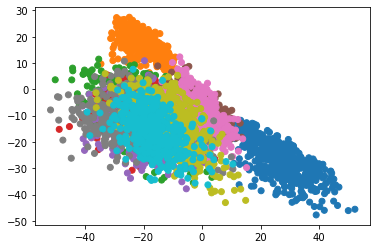

In [115]:
emb = dr.model(testdata).detach()
plt.scatter(
    x=emb[:,0],
    y=emb[:,1],
    c=[ plt.get_cmap('tab10')(t) for t in testtargets ]
)

In [126]:
(emb.softmax(dim=1).argmax(dim=1) == torch.tensor(testtargets)).sum()

tensor(5000)

In [134]:
prediction = dr.model(mnist.data.reshape(-1, 28*28) / 255.)[6000:7000].softmax(dim=1).argmax(dim=1)

In [136]:
(prediction == mnist.targets[6000:7000]).sum()

tensor(937)